# Derive an empirical BarShadow calibration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import astropy.io.fits as pyfits

from tqdm import tqdm
import scipy.ndimage as nd

import eazy

import grizli
from grizli import utils

import msaexp
import msaexp.slit_combine
import msaexp.utils

print('grizli: ', grizli.__version__)
print('msaexp: ', msaexp.__version__)


Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
grizli:  1.11.10
msaexp:  0.8.6.dev20+g2a4a18e.d20240815


In [2]:
try:
    os.chdir('/Users/gbrammer/Research/JWST/Projects/NIRSpec/FlagStuckClosed')
except:
    pass

print(os.getcwd())

/Users/gbrammer/Research/JWST/Projects/NIRSpec/FlagStuckClosed


## Sync background slit cutouts from DD-2750 masks

That program is particularly useful because
1. There are 9 deep exposures
2. There are a lot of background slitlets in all 1-, 2-, and 3-shutter configurations

In [4]:
# for root in ['rubies-egs61-v3', 'rubies-egs62-v3']:
#     print(f'# sync from {root}')
#     os.system(f'aws s3 sync s3://msaexp-nirspec/extractions/slitlets/{root}/ ./ --exclude "*" --include "*phot.*_m*.fits"')

if len(glob.glob('jw02750*')) == 0:
    for root in ['ceers-ddt-v3']:
        print(f'# sync from {root}')
        os.system(f'aws s3 sync s3://msaexp-nirspec/extractions/slitlets/{root}/ ./ --exclude "*" --include "*phot.*.b*.fits"')
    

In [5]:
# files = glob.glob('jw*4233_m*fits')
# files = glob.glob('jw02750002001_0310*.b*.fits')
# All DD-2750 files
files = glob.glob('jw02750002*.b*.fits')

print(len(files))

files.sort()
files = np.array(files)
keys = ['.'.join(f.split('_')[:1]) + '.' + f.split('_')[3] + '.' + f.split('.')[1] for f in files]
un = utils.Unique(keys)

1677
   N  value     
====  ==========
   3  jw02750002001.nrs1.145
   3  jw02750002001.nrs2.145
   3  jw02750002001.nrs1.238
   3  jw02750002001.nrs1.174
   9  jw02750002001.nrs2.038
   9  jw02750002001.nrs2.039
   9  jw02750002001.nrs2.040
   9  jw02750002001.nrs2.041
   9  jw02750002001.nrs2.042
   9  jw02750002001.nrs2.043
   9  jw02750002001.nrs2.045
   9  jw02750002001.nrs2.046
   9  jw02750002001.nrs2.049
   9  jw02750002001.nrs1.109
   9  jw02750002001.nrs2.051
   9  jw02750002001.nrs2.054
   9  jw02750002001.nrs2.055
   9  jw02750002001.nrs2.057
   9  jw02750002001.nrs2.058
   9  jw02750002001.nrs2.059
   9  jw02750002001.nrs2.061
   9  jw02750002001.nrs2.062
   9  jw02750002001.nrs2.063
   9  jw02750002001.nrs2.034
   9  jw02750002001.nrs2.032
   9  jw02750002001.nrs2.027
   9  jw02750002001.nrs2.064
   9  jw02750002001.nrs2.002
   9  jw02750002001.nrs2.004
   9  jw02750002001.nrs2.006
   9  jw02750002001.nrs2.007
   9  jw02750002001.nrs2.008
   9  jw02750002001.nrs2.009
   9

# Read into `msaexp.slit_combine.SlitGroup` objects

In [27]:
from importlib import reload

bobj = {}

# By shutter groups
num_shutters = 3
num_shutters = 2
num_shutters = 1

num_shutters = 0 # Read everything for sky ratios

for ik, k in enumerate(un.values):

    print(f'{ik+1} / {un.N} {k}\n\n')
    
    if un[k].sum() >= 3:
        with pyfits.open(files[un[k]][0]) as im:
            if (len(im[1].header['SHUTSTA']) != num_shutters) & (num_shutters > 0):
                print('skip', k, im[1].header['SHUTSTA'])
                continue

            if im[1].header['NAXIS1'] < 200:
                continue
            
        _obj = msaexp.slit_combine.SlitGroup(files[un[k]],
                                             'test',
                                             position_key='y_index',
                                             undo_pathloss=True,
                                             trace_with_ypos=True, 
                                             trace_from_yoffset=True,
                                             stuck_min_sn=-100,
                                             undo_barshadow=False,
                                             fix_prism_norm=False,
                                             pad_border=0,
                                             nod_offset=None,
                                             sky_file=None,
                                            )

        # only by shutter
        if (len(_obj.info['shutter_state'][0]) != num_shutters) & (num_shutters > 0):
            continue

        # Only mostly complete spectra
        if _obj.sh[1] > 200:
            bobj[k] = _obj
            obj = _obj
            # break

1 / 189 jw02750002001.nrs1.109


2 / 189 jw02750002001.nrs1.113


3 / 189 jw02750002001.nrs1.118


4 / 189 jw02750002001.nrs1.121


5 / 189 jw02750002001.nrs1.122


6 / 189 jw02750002001.nrs1.123


7 / 189 jw02750002001.nrs1.124


8 / 189 jw02750002001.nrs1.129


9 / 189 jw02750002001.nrs1.135


10 / 189 jw02750002001.nrs1.138


11 / 189 jw02750002001.nrs1.143


12 / 189 jw02750002001.nrs1.144


13 / 189 jw02750002001.nrs1.145


 0 jw02750002001_03101_00002_nrs1_phot.145.b145.fits (19, 219)  0 flagged hot pixels
 1 jw02750002001_05101_00002_nrs1_phot.145.b145.fits (19, 219)  0 flagged hot pixels
 2 jw02750002001_07101_00002_nrs1_phot.145.b145.fits (19, 219)  0 flagged hot pixels
   jw02750002001_03101_00002_nrs1_phot.145.b145.fits source_type=None  undo PATHLOSS_UN
   jw02750002001_05101_00002_nrs1_phot.145.b145.fits source_type=None  undo PATHLOSS_UN
   jw02750002001_07101_00002_nrs1_phot.145.b145.fits source_type=None  undo PATHLOSS_UN
Seems to be a background slit.  Force   0.0 pix 

In [28]:
# Show one slitlet
for k in bobj:    
    obj = bobj[k]
    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    if len(obj.info["shutter_state"][0]) != 3:
        continue
    
    if 'nrs1' in k:
        continue
        
    print(k)
    break

jw02750002001.nrs2.002


/Users/gbrammer/miniconda3/envs/jw310-2024/lib/python3.10/site-packages/numpy/core/numerictypes.py:511: RuntimeWarning: invalid value encountered in cast
  cast[key] = lambda x, k=key: array(x, copy=False).astype(k)


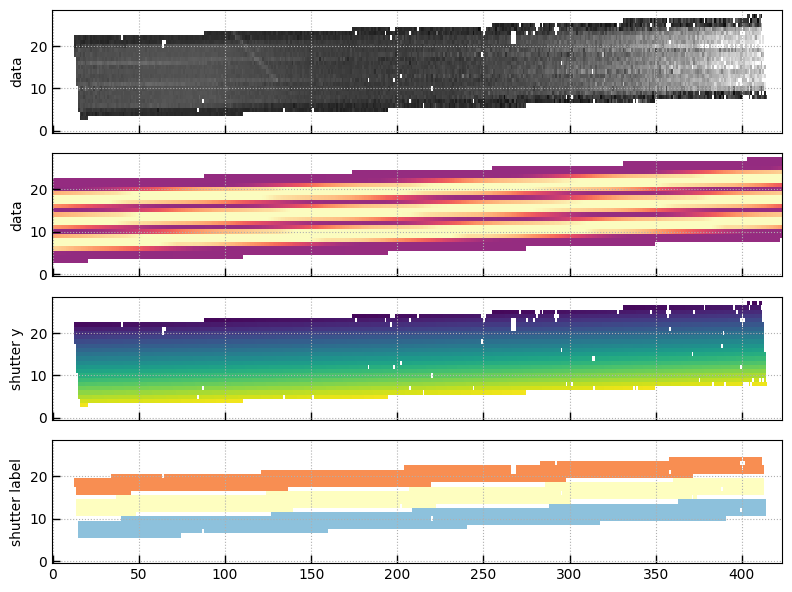

In [29]:
fig, axes = plt.subplots(4,1,figsize=(8, 6), sharex=True, sharey=True)

# Data
ax = axes[0]
ax.imshow(obj.sci[0].reshape(obj.sh), aspect='auto', vmin=-0.1, vmax=0.5, cmap='gray')
ax.set_ylabel('data')

# CRDS bar shadow correction
ax = axes[1]
ax.imshow(obj.bar[0].reshape(obj.sh), aspect='auto', vmin=0, vmax=1, cmap='magma')
ax.set_ylabel('data')

# Show shutter coordinates
ax = axes[2]
shutter_y = obj.fixed_yshutter*1
shutter_y[~obj.mask] = np.nan

ax.imshow(shutter_y[0,:].reshape(obj.sh),
          aspect='auto', vmin=-2, vmax=2)
ax.set_ylabel('shutter y')

# Show distinct shutters
ax = axes[3]
shutter_index = np.cast[int](np.round(shutter_y))*1.
shutter_index[(obj.bar < 0.5) | ~np.isfinite(obj.sci)] = np.nan

ax.imshow(shutter_index[0,:].reshape(obj.sh),
          aspect='auto', vmin=-2, vmax=2, cmap='RdYlBu')

ax.set_ylabel('shutter label')

for ax in axes:
    ax.grid()
    
fig.tight_layout(pad=1)


## Compute average sky spectrum

Here just used to normalize the 2D arrays

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 358.09it/s]


iter0 399880
iter1 439614


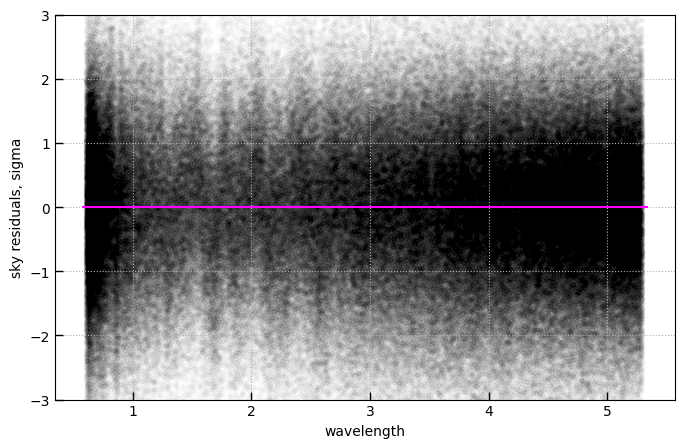

In [30]:
from tqdm import tqdm
import scipy.ndimage as nd
import msaexp.utils as msautils

fig, ax = plt.subplots(1,1,figsize=(8, 5))

ydata = []
fdata = []
wdata = []
edata = []
rndata = []

for k in tqdm(bobj):
    obj = bobj[k]
    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    # Just compute average from NRS2
    if 'nrs1' in k:
        continue
    
    sn = obj.sci*1
    sne = np.sqrt(obj.var_total)
    rn = np.sqrt(obj.var_rnoise)

    # bkg_root = obj.slits[0].meta.filename.split('_nrs')[0]
    # bkg_file = glob.glob(f'{bkg_root}*s200a1.spec.fits')

    # if len(bkg_file) > 0:
    #     bkg_spec = utils.read_catalog(bkg_file[0])
    #     print(bkg_file[0])
    #     okw = np.isfinite(bkg_spec['wave'])
    #     sn /= np.interp(obj.wave, bkg_spec['wave'][okw], bkg_spec['spl_flux'][okw])
        
    # if obj.position_key == "manual_position":
    #     shutter_y = (obj.yshutter + obj.source_ypixel_position - 1)/5
    # else:
    #     shutter_y = (obj.yshutter + obj.source_ypixel_position)/5
    shutter_y = obj.fixed_yshutter
    
    y_shutter_index = (obj.yslit + 1)/5

    oky = np.isfinite(shutter_y + obj.bar + sn) & (sn > -0.1) & (sn < 1)

    shutter_mid = np.abs(y_shutter_index - np.round(y_shutter_index)) < 0.2
    shutter_mid &= np.isfinite(obj.wave + obj.sci)
    shutter_mid &= obj.bar > 0.95
    
    oky &= shutter_mid

    wsub = oky & (np.abs(obj.wave - 1.7) < 0.3) & np.isfinite(sn)
    if wsub.sum() < 256:
        continue
        
    # ax.scatter(obj.wave[oky], sn[oky], alpha=0.1)
    
    ydata.append(shutter_y[oky])
    wdata.append(obj.wave[oky])
    fdata.append(sn[oky])
    edata.append(sne[oky])
    rndata.append(rn[oky])

if 1:
    # Scale
    N = len(wdata)
    rescale = np.zeros(N)
    
    for i in range(N):
        wsub = np.abs(wdata[i] - 1.7) < 0.3
        rescale[i] = np.nanmedian(fdata[i][wsub])
    
    rescale /= np.median(rescale)
    for i in range(N):
        fdata[i] /= rescale[i]
        edata[i] /= rescale[i]
        rndata[i] /= rescale[i]

    keep = np.where((rescale > 0.9) & (rescale < 1.1))[0]
else:
    keep = np.arange(len(wdata), dtype=int)
    
ydata =  np.hstack([ydata[i] for i in keep])
wdata =  np.hstack([wdata[i] for i in keep])
fdata =  np.hstack([fdata[i] for i in keep])
edata =  np.hstack([edata[i] for i in keep])
rndata = np.hstack([rndata[i] for i in keep])

so = np.argsort(wdata)

sky_wave, sky_flux = wdata[so], nd.median_filter(fdata[so], 60)
okx = np.abs(fdata[so] - sky_flux) < 2*edata[so]
sky_wave, sky_flux = wdata[so][okx], nd.gaussian_filter(fdata[so][okx], 60)

# Fit cubic splines to sky
sky_df = 81

sky_df = 31

if 0:
    # Order by wavelength
    wrange = (0.6, 5.4)
    bspl = utils.bspline_templates(wdata, df=sky_df, minmax=wrange, get_matrix=True)
    splx = np.linspace(*wrange, 1024)
    wgrid = splx
    bsplm = utils.bspline_templates(splx, df=sky_df, minmax=wrange, get_matrix=True)
else:
    # order by variable prism resolution
    wgrid = msautils.get_standard_wavelength_grid('PRISM', sample=1.0)
    ngrid = len(wgrid)
    splx = np.arange(ngrid)/ngrid
    xdata = np.interp(wdata, wgrid, splx)
    wrange = (0,1)
    
    bspl = utils.bspline_templates(xdata, df=sky_df, minmax=wrange, get_matrix=True)
    bsplm = utils.bspline_templates(splx, df=sky_df, minmax=wrange, get_matrix=True)


_csky = np.linalg.lstsq((bspl.T/rndata).T[so[okx],:], (fdata/rndata)[so][okx], rcond=None)
sky0 = bspl.dot(_csky[0])
print('iter0', okx.sum())
okx = np.abs(fdata[so] - sky0[so]) < 3*edata[so]
print('iter1', okx.sum())
_csky = np.linalg.lstsq((bspl.T/rndata).T[so[okx],:], (fdata/rndata)[so][okx], rcond=None)
sky1 = bspl.dot(_csky[0])

ax.scatter(wdata[so], (fdata[so] - sky1[so]) / edata[so], color='k', alpha=0.01)

sply = bsplm.dot(_csky[0])

ax.plot(wgrid, sply*0, color='magenta')
ax.set_xlabel('wavelength')
ax.set_ylabel('sky residuals, sigma')
# ax.set_ylabel('sky flux density, uJy')

average_sky_wave = wgrid
average_sky_flux = sply*1.

ax.set_ylim(-3, 3)
ax.grid()

# plt.ylim(-0.1, 0.6)

## Compare individual sky spectra to average

Seem to be some trends as a function of detector position, which could indicate additional detector- and/or field-dependent corrections to the SFLAT.

### First, estimate sky spectrum in each group

In [31]:
for k in bobj:
    obj = bobj[k]
    if (not hasattr(obj, 'sky_data')) | (1):
        obj.estimate_sky(make_plot=False, mask_slit=[100,-100], df=sky_df)

 estimate_sky                : 830 outliers > 7  / N=1263 sky pixels 
 estimate_sky                : 3373 outliers > 7  / N=3933 sky pixels 
 estimate_sky                : 4252 outliers > 7  / N=8393 sky pixels 
 estimate_sky                : 3261 outliers > 7  / N=3078 sky pixels 
 estimate_sky                : 3683 outliers > 7  / N=4371 sky pixels 
 estimate_sky                : 1016 outliers > 7  / N=3456 sky pixels 
 estimate_sky                : 4120 outliers > 7  / N=9252 sky pixels 
 estimate_sky                : 3150 outliers > 7  / N=2826 sky pixels 
 estimate_sky                : 4329 outliers > 7  / N=4567 sky pixels 
 estimate_sky                : 3319 outliers > 7  / N=3104 sky pixels 
 estimate_sky                : 930 outliers > 7  / N=2573 sky pixels 
 estimate_sky                : 3273 outliers > 7  / N=2849 sky pixels 
 estimate_sky                : 4510 outliers > 7  / N=7479 sky pixels 
 estimate_sky                : 4460 outliers > 7  / N=9081 sky pixels 
 estimat

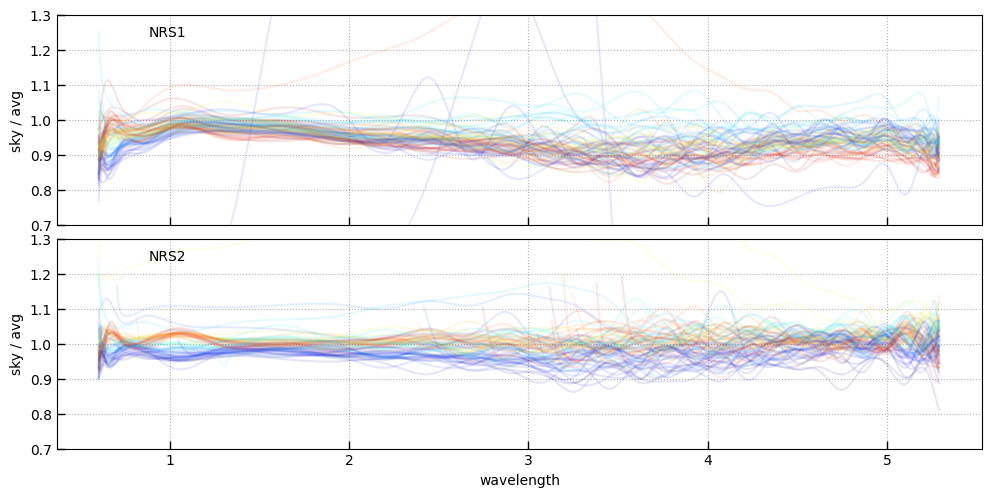

In [32]:
# Plot the comparison
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True, sharey=True)

for k in bobj:
    obj = bobj[k]

    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    if obj.slits[0].meta.instrument.detector == 'NRS1':
        ax = axes[0]
    else:
        ax = axes[1]
    
    y_shutter_index = (obj.yslit + 1)/5

    shutter_mid = np.abs(y_shutter_index - np.round(y_shutter_index)) < 0.2
    shutter_mid &= np.isfinite(obj.wave + obj.sci)
    
    so = np.argsort(obj.wave[shutter_mid])
    wso = obj.wave[shutter_mid][so]
    
    _sky_wave, _sky_flux = obj.sky_data['sky_wave'], obj.sky_data['sky_model']
    _sky_flux[(_sky_wave < wso.min()) | (_sky_wave > wso.max())] = np.nan

    _skyx = np.interp(_sky_wave, wgrid, splx)
    
    _spl = utils.bspline_templates(_skyx, df=sky_df, minmax=wrange, get_matrix=True)
    _sky_avg = _spl.dot(_csky[0])
            
    ax.plot(_sky_wave, _sky_flux / _sky_avg, alpha=0.1, color=plt.cm.jet(obj.slits[0].ystart/2048.))

for i, ax in enumerate(axes):
    ax.grid()
    ax.set_ylim(0.7, 1.3)
    ax.set_ylabel('sky / avg')
    ax.text(0.1, 0.95, f'NRS{i+1}', ha='left', va='top', transform=ax.transAxes)
    
ax.set_xlabel('wavelength')

fig.tight_layout(pad=1)

## Concatenate into big arrays

In [33]:
import eazy

ydata = []
fdata = []
wdata = []
rdata = []
bdata = []
braw = []
rndata = []
nshut = []

wcen, wwid = 1., 1.0

wcen, wwid = 4.5, 10.5
wcen, wwid = 1.5, 0.5

slit_data = []

for k in bobj:    
    obj = bobj[k]
    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    if 'xnrs1' in k:
        continue
    
    _spl = utils.bspline_templates(np.interp(obj.wave.flatten(), wgrid, splx),
                                   df=sky_df, minmax=wrange, get_matrix=True)
    _sky = _spl.dot(_csky[0]).reshape(obj.wave.shape)
    
    # _sky = obj.sky_data['sky2d']*1
    
    if 0:
        # Use master sky
        bkg_files = []
        for slit in obj.slits:
            bkg_root = obj.slits[0].meta.filename.split('_nrs')[0]
            bkg_files += glob.glob(f'{bkg_root}*s200a1.spec.fits')
        
        if len(bkg_files) > 0:
            avg_bkg_spec = []
            for bkg_file in bkg_files:
                bkg_spec = utils.read_catalog(bkg_file)
                avg_bkg_spec.append(bkg_spec['spl_flux'])
    
            avg_bkg_spec = np.nanmean(avg_bkg_spec, axis=0) * 1.1
            
            # print(bkg_file[0])
            okw = np.isfinite(bkg_spec['wave'] + avg_bkg_spec)
        
            _sky = np.interp(obj.wave.flatten(), bkg_spec['wave'][okw], avg_bkg_spec[okw]).reshape(obj.wave.shape)
    else:
        slit = obj.slits[0]
    
    # Data is science data / average sky * bar (to undo the bar correction)
    sn = obj.sci*1 / _sky * obj.bar
    rn = obj.var_rnoise*1 / _sky
    
    shutter_y = obj.fixed_yshutter

    cbar, _warp = msaexp.utils.get_prism_bar_correction(shutter_y, wrap=False)

    oky = np.isfinite(shutter_y + obj.bar + sn) & (sn > 0) & (sn < 1.5)
    scale_sky = np.nanmedian((sn/obj.bar)[oky & (obj.bar > 0.95) & (np.abs(obj.wave - wcen) < wwid)])
    
    print(k, scale_sky)
    if (scale_sky > 1.08) | (scale_sky < 0.8):
        continue

    if ~np.isfinite(scale_sky):
        continue

    coeffs = np.zeros(sky_df)*np.nan
    coeffs[obj.sky_data['spl_trim']] = obj.sky_data['sky_coeffs'][0]

    ecoeffs = np.zeros(sky_df)*np.nan
    ecoeffs[obj.sky_data['spl_trim']] = np.sqrt(obj.sky_data['sky_covar'].diagonal())

    slit_data.append([slit.quadrant, slit.xcen, slit.ycen, slit.ystart,
                      slit.meta.instrument.detector, len(slit.shutter_state), scale_sky, coeffs, ecoeffs])
    
    sn /= scale_sky
    rn /= scale_sky**2
    
    if 'jw02565' in files[0]:
        oky &= np.abs(shutter_y) < 2.5
    # else:
    #     oky &= np.abs(shutter_y) < 1.5
    
    if 0:
        # Try just computing a single shutter
        shutter_y = ((shutter_y + 0.5) % 1) - 0.5

    num_shutters = len(obj.info["shutter_state"][0])
    
    ydata.append(shutter_y[oky])
    wdata.append(obj.wave[oky])
    fdata.append(sn[oky])
    rndata.append(rn[oky])
    rdata.append((obj.sci / scale_sky)[oky]*1)
    bdata.append((obj.bar / cbar)[oky]*1)
    braw.append((obj.bar)[oky]*1)
    nshut.append(np.ones(oky.sum())*num_shutters)
                 
ydata = np.hstack(ydata)
wdata = np.hstack(wdata)
fdata = np.hstack(fdata)
rndata = np.hstack(rndata)
rdata = np.hstack(rdata)
bdata = np.hstack(bdata)
braw = np.hstack(braw)
nshut = np.hstack(nshut)

jw02750002001.nrs1.145 1.0130660938043405
jw02750002001.nrs1.147 0.9993274624564098
jw02750002001.nrs1.169 1.0040294993298435
jw02750002001.nrs1.171 0.993063753216963
jw02750002001.nrs1.174 0.9948972425394982
jw02750002001.nrs1.175 0.9946547675396495
jw02750002001.nrs1.177 1.0002614003689696
jw02750002001.nrs1.182 0.9883566859405287
jw02750002001.nrs1.188 0.1853452902750048
jw02750002001.nrs1.189 0.9793229491210104
jw02750002001.nrs1.190 0.9859097782733508
jw02750002001.nrs1.196 0.9978584883752353
jw02750002001.nrs1.199 0.9771826243710544
jw02750002001.nrs1.203 0.9767709904783118
jw02750002001.nrs1.206 0.9869391661536016
jw02750002001.nrs1.208 0.9815094126958422
jw02750002001.nrs1.211 0.9818376633148419
jw02750002001.nrs1.212 0.9807485863363795
jw02750002001.nrs1.214 0.9822925955141165
jw02750002001.nrs1.216 0.9909316710193979
jw02750002001.nrs1.217 0.9907796549977611
jw02750002001.nrs1.218 0.9992225380641752
jw02750002001.nrs1.219 0.9787116653614647
jw02750002001.nrs1.221 1.0213349164

/Users/gbrammer/miniconda3/envs/jw310-2024/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


jw02750002001.nrs2.109 nan
jw02750002001.nrs2.110 0.9988863056436075
jw02750002001.nrs2.111 0.9895866941139259
jw02750002001.nrs2.112 nan
jw02750002001.nrs2.113 nan
jw02750002001.nrs2.116 0.9706524796231667
jw02750002001.nrs2.118 nan
jw02750002001.nrs2.119 0.9725188686408881
jw02750002001.nrs2.120 0.9730885206589894
jw02750002001.nrs2.121 nan
jw02750002001.nrs2.123 nan
jw02750002001.nrs2.124 nan
jw02750002001.nrs2.126 nan
jw02750002001.nrs2.127 1.0580636021988916
jw02750002001.nrs2.128 0.9782135888408382
jw02750002001.nrs2.129 nan
jw02750002001.nrs2.130 0.9930732307734947
jw02750002001.nrs2.132 0.9845966197691729
jw02750002001.nrs2.133 1.0050177778239269
jw02750002001.nrs2.137 0.9703656511398472
jw02750002001.nrs2.141 nan
jw02750002001.nrs2.149 nan
jw02750002001.nrs2.153 nan


## Normalization by MSA position

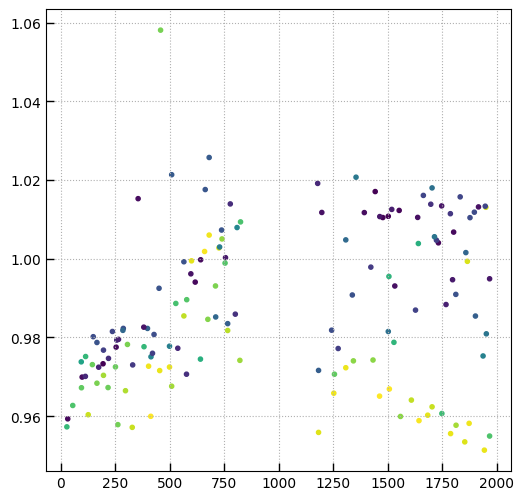

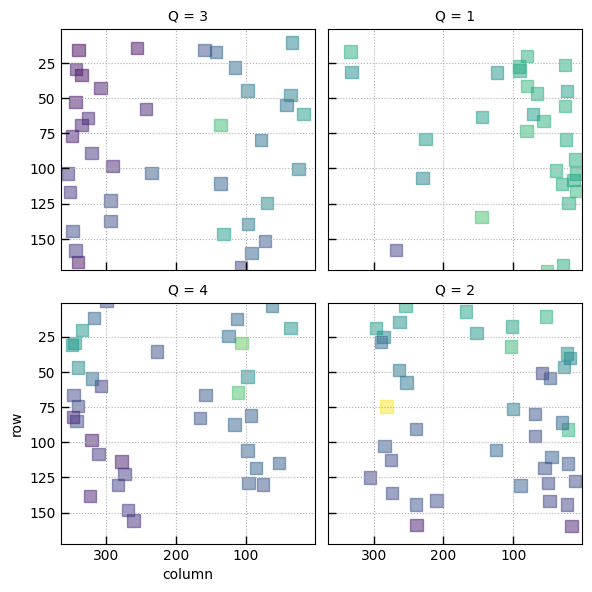

In [34]:
slit_data_info = utils.GTable(rows=slit_data, names=['quadrant','xcen','ycen', 'ystart', 'detector',
                                                     'num_shutters','scale','coeffs', 'coeffs_err'])

plt.scatter(slit_data_info['ystart'], slit_data_info['scale'], c=slit_data_info['xcen']) #, vmin=0, vmax=2)
plt.grid()

fig, xaxes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)
axes = [xaxes[0][1], xaxes[1][1], xaxes[0][0], xaxes[1][0]]

vm = np.nanpercentile(slit_data_info['scale'], [2, 99])
vm = [0.9, 1.08]
vm = [0.95, 1.05]

np.random.seed(1)

for q in [1,2,3,4]:
    ax = axes[q-1]
    qi = slit_data_info['quadrant'] == q
    ax.scatter(slit_data_info['xcen'][qi] + 2*np.random.normal(size=qi.sum()),
               slit_data_info['ycen'][qi] + 2*np.random.normal(size=qi.sum()),
               c=slit_data_info['scale'][qi], 
               vmin=vm[0], vmax=vm[1],
               marker='s', s=80, alpha=0.5
              ) 
    
    ax.grid()
    ax.set_title(f'Q = {q}')

    ax.set_xlim(365, 1)
    ax.set_ylim(172, 1)

ax.set_xlabel('column')
ax.set_ylabel('row')

fig.tight_layout(pad=1)

i = -1

## Derive a normalization correction by fitting for the sky residual coefficients as a function of position

In [38]:
i = -1
crows = []
print(sky_df)

31


spline coeff[0]
spline coeff[1]
spline coeff[2]
spline coeff[3]
spline coeff[4]
spline coeff[5]
spline coeff[6]
spline coeff[7]
spline coeff[8]
spline coeff[9]
spline coeff[10]
spline coeff[11]
spline coeff[12]
spline coeff[13]
spline coeff[14]
spline coeff[15]
spline coeff[16]
spline coeff[17]
spline coeff[18]
spline coeff[19]
spline coeff[20]
spline coeff[21]
spline coeff[22]
spline coeff[23]
spline coeff[24]
spline coeff[25]
spline coeff[26]
spline coeff[27]
spline coeff[28]
spline coeff[29]
spline coeff[30]


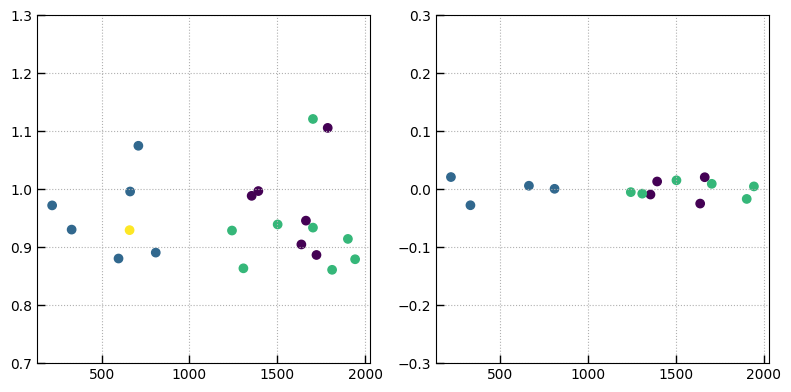

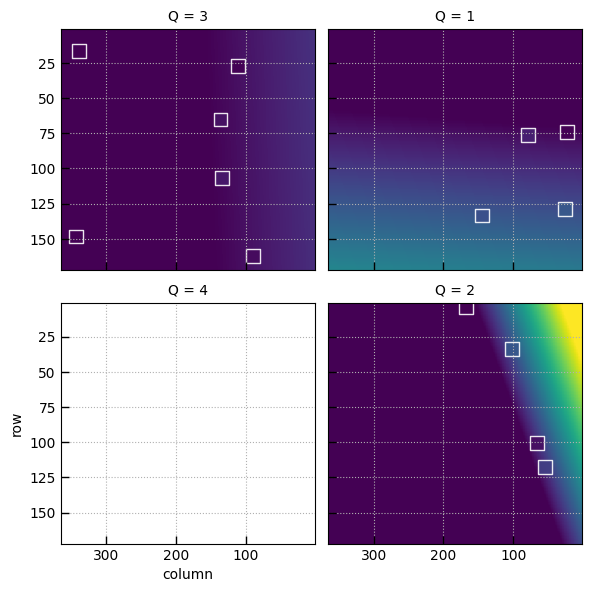

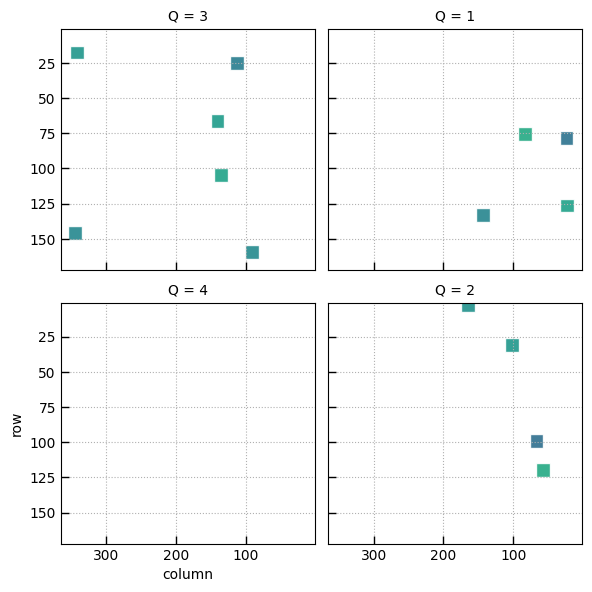

In [39]:
crows = []

for i in range(sky_df):
        
    print(f'spline coeff[{i}]')
    cratio = slit_data_info['coeffs'][:,i] / _csky[0][i]
    eratio = slit_data_info['coeffs_err'][:,i] / _csky[0][i]
    
    if i == 0:
        valid = (cratio > 0.7) & (cratio < 1.3)
    else:
        valid = (cratio > 0.85) & (cratio < 1.2)
    
    f0, axes0 = plt.subplots(1,2,figsize=(8,4))
    
    axes0[0].errorbar(slit_data_info['ystart'][valid], cratio[valid], eratio[valid], marker='.', zorder=-10, linestyle='None')
    axes0[0].scatter(slit_data_info['ystart'][valid], cratio[valid], c=slit_data_info['quadrant'][valid], marker='o') #, vmin=0, vmax=2)
    axes0[0].set_ylim(0.7, 1.3)
    
    fig, xaxes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)
    axes1 = [xaxes[0][1], xaxes[1][1], xaxes[0][0], xaxes[1][0]]
    
    fig2, xaxes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)
    axes2 = [xaxes[0][1], xaxes[1][1], xaxes[0][0], xaxes[1][0]]
    
    vm = [0.9, 1.08]
    vm = [0.92, 1.2]
    
    np.random.seed(1)
    
    from astropy.modeling.models import Polynomial2D
    from astropy.modeling.fitting import LinearLSQFitter
    
    m = Polynomial2D(degree=1)
    fit = LinearLSQFitter()
    
    sh = (175, 365)
    yy, xx = np.indices(sh)
    
    qrows = []
    
    for q in [1,2,3,4]:
        ax1 = axes1[q-1]
        ax2 = axes2[q-1]
        qi = (slit_data_info['quadrant'] == q) & valid
        if qi.sum() == 0:
            qrow = [np.nan, 0., 0.]
            qrows.append(qrow)
            continue

        qi &= (cratio > cratio[qi].min()) & (cratio < cratio[qi].max())
        
        pfit = fit(m, slit_data_info['xcen'][qi], slit_data_info['ycen'][qi], cratio[qi])
        if i == 0:
            qrow = [float(np.median(cratio[qi])), 0., 0.]
        else:
            qrow = [float(f) for f in pfit.parameters]
            
        qrows.append(qrow)
        
        pval = pfit(xx, yy)
        ax1.imshow(pval, vmin=vm[0], vmax=vm[1], aspect='auto')
    
        ax1.scatter(slit_data_info['xcen'][qi] + 2*np.random.normal(size=qi.sum()),
                   slit_data_info['ycen'][qi] + 2*np.random.normal(size=qi.sum()),
                   c=cratio[qi], 
                   vmin=vm[0], vmax=vm[1],
                   ec='w',
                   marker='s', s=100, alpha=0.9
                  ) 
        
        pval = pfit(slit_data_info['xcen'][qi], slit_data_info['ycen'][qi])
        ax2.scatter(slit_data_info['xcen'][qi] + 2*np.random.normal(size=qi.sum()),
                   slit_data_info['ycen'][qi] + 2*np.random.normal(size=qi.sum()),
                   c=cratio[qi] - pval, 
                   vmin=-0.1, vmax=0.1,
                   ec='w',
                   marker='s', s=100, alpha=0.9
                  ) 
    
        axes0[1].errorbar(slit_data_info['ystart'][qi], cratio[qi] - pval, eratio[qi], marker='.', color='k', alpha=0.5, zorder=-10, linestyle='None')
        axes0[1].scatter(slit_data_info['ystart'][qi], cratio[qi] - pval, c=slit_data_info['quadrant'][qi], vmin=1, vmax=4, marker='o') #, vmin=0, vmax=2)
        axes0[1].set_ylim(-0.3, 0.3)
    
        for ax in [ax1, ax2]:
            ax.grid()
            ax.set_title(f'Q = {q}')
        
            ax.set_xlim(365, 1)
            ax.set_ylim(172, 1)
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('column')
        ax.set_ylabel('row')
    
    fig.tight_layout(pad=1)
    fig2.tight_layout(pad=1)
    for ax in axes0:
        ax.grid()
        
    f0.tight_layout(pad=1)
    crows.append(qrows)

    if i != 6:
        plt.close(); plt.close(); plt.close()

### save to a reference file

In [40]:
# Save to a reference file

import yaml
def float_representer(dumper, value):
    text = "{0:.5f}".format(value)
    return dumper.represent_scalar("tag:yaml.org,2002:float", text)

yaml.add_representer(float, float_representer)

_header = """# empirical-bar-shadow.ipynb
# Determined from background shutters DD-2750
"""

### No wavelength dependence
slit_norm = {}
slit_norm['df'] = sky_df
slit_norm['coeffs'] = crows
slit_norm['reference_wavelengths'] = [float(w) for w in obj.sky_data['sky_wave']]

if False:
    with open(f'prism_slit_renormalize.yaml','w') as fp:
        fp.write(_header)
        yaml.dump(slit_norm, stream=fp)


### show normalization corrections

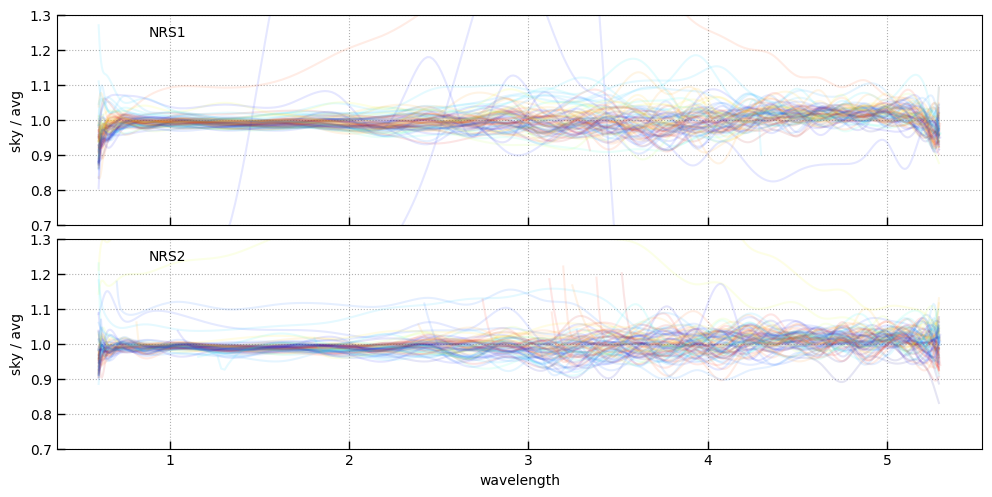

In [41]:
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True, sharey=True)

for k in bobj:
    obj = bobj[k]

    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    if obj.slits[0].meta.instrument.detector == 'NRS1':
        ax = axes[0]
    else:
        ax = axes[1]

    _sky_wave, _sky_flux = obj.sky_data['sky_wave'], obj.sky_data['sky_model']

    # Get the correction
    slit = obj.slits[0]
    corr = msautils.get_normalization_correction(obj.sky_data['sky_wave'],
                                                 slit.quadrant, slit.xcen, slit.ycen, grating='PRISM',
                                                 verbose=False,
                                                )

    ax.plot(_sky_wave, _sky_flux / average_sky_flux * corr, alpha=0.1, color=plt.cm.jet(obj.slits[0].ystart/2048.))
    
for i, ax in enumerate(axes):
    ax.grid()
    ax.set_ylim(0.7, 1.3)
    ax.set_ylabel('sky / avg')
    ax.text(0.1, 0.95, f'NRS{i+1}', ha='left', va='top', transform=ax.transAxes)
    
ax.set_xlabel('wavelength')

fig.tight_layout(pad=1)


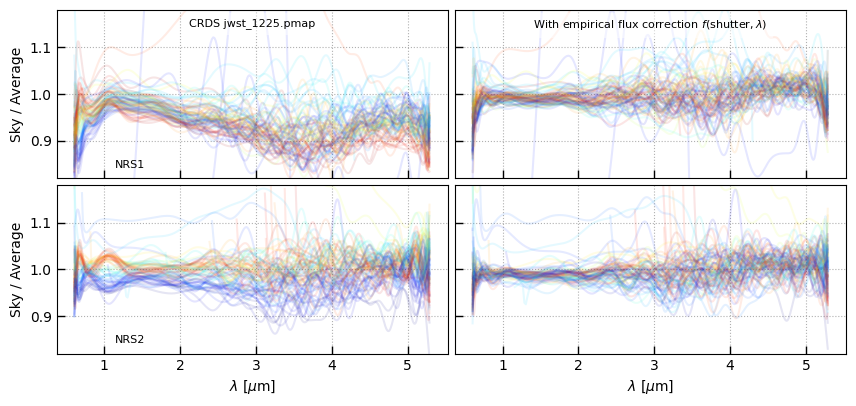

In [74]:
# Figure with before and after

fig, axes = plt.subplots(2,2,figsize=(8.5,4), sharex=True, sharey=True)

for k in bobj:
    obj = bobj[k]

    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    if obj.slits[0].meta.instrument.detector == 'NRS1':
        j = 0
    else:
        j = 1

    _sky_wave, _sky_flux = obj.sky_data['sky_wave'], obj.sky_data['sky_model']

    # Get the correction
    slit = obj.slits[0]
    corr = msautils.get_normalization_correction(obj.sky_data['sky_wave'],
                                                 slit.quadrant, slit.xcen, slit.ycen, grating='PRISM',
                                                 verbose=False,
                                                )

    axes[j][0].plot(_sky_wave, _sky_flux / average_sky_flux, alpha=0.1, color=plt.cm.jet(obj.slits[0].ystart/2048.))
    axes[j][1].plot(_sky_wave, _sky_flux / average_sky_flux * corr, alpha=0.1, color=plt.cm.jet(obj.slits[0].ystart/2048.))

for j in [0,1]:
    for i in [0,1]:
        ax = axes[j][i]
        ax.grid()
        ax.set_ylim(0.82, 1.18)
    
        if i == 0:
            pass
            # ax.set_ylabel(f'NRS{j+1}')
            ax.text(0.15, 0.05, f'NRS{j+1}', ha='left', va='bottom', transform=ax.transAxes, size=8)

# axes[0][0].set_title('CRDS jwst_1225.pmap')
#axes[0][1].set_title(r'With empirical correction $f(\mathrm{shutter}, \lambda)$')

axes[0][0].text(0.5, 0.95, r'CRDS jwst_1225.pmap',
                ha='center', va='top', transform=axes[0][0].transAxes,
                size=8,
                bbox={'fc':'w', 'alpha':0.5, 'ec':'None'})

axes[0][1].text(0.5, 0.95, r'With empirical flux correction $f(\mathrm{shutter}, \lambda)$',
                ha='center', va='top', transform=axes[0][1].transAxes,
                size=8,
                bbox={'fc':'w', 'alpha':0.5, 'ec':'None'})

for i in [0,1]:
    axes[1][i].set_xlabel(r'$\lambda$ [$\mu\mathrm{m}$]')

for i in [0,1]:
    axes[i][0].set_ylabel('Sky / Average')

# fig.supylabel('Sky / Average')

fig.tight_layout(pad=0.5)
fig.savefig('prism_sky_flux_correction.pdf')

## Now derive the bar correction from the cross-dispersion profiles

### Split by number of shutters

The profiles are different for 1-, 2-, and 3-shutter slitlets. 

In [75]:
num_shutters = 3
select_shutters = nshut == num_shutters

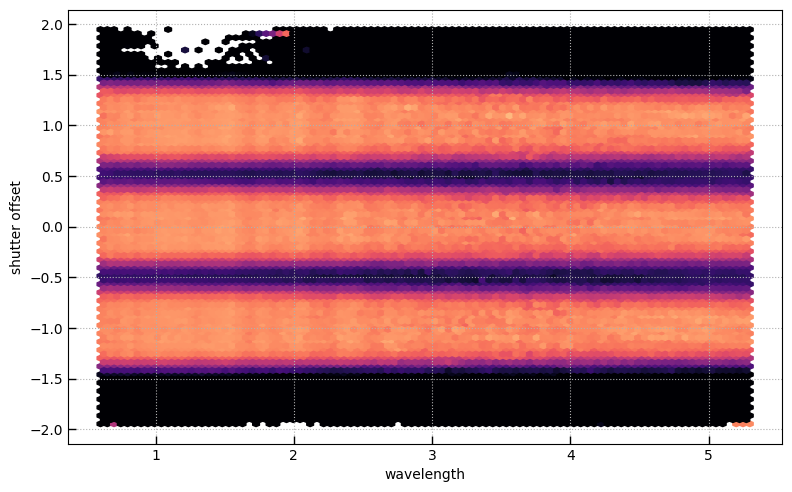

In [76]:
fig, ax = plt.subplots(1,1,figsize=(8, 5))

bin_xvalue = wdata

if 1:
    ax.hexbin(bin_xvalue[select_shutters],
              ydata[select_shutters],
              C=fdata[select_shutters],
              gridsize=(96,16*num_shutters),
              reduce_C_function=np.nanmedian, vmin=0.3, vmax=1.2,
              cmap='magma',
          )
else:
    ax.hexbin(bin_xvalue, ydata, C=rdata*bdata**1,
          gridsize=(72,36),
          reduce_C_function=np.nanmedian, vmin=-0.1, vmax=0.2,
           cmap='magma',
          )

ax.grid()
ax.set_xlabel('wavelength')
ax.set_ylabel('shutter offset')
fig.tight_layout(pad=1)


### fit the profile

Fit with the flexible spline functions (as usual!)

- `df` = number of spline basis functions
- `bar_minmax` = range of shutter coordinates to consider

In [77]:
# df is the number of basis functions

if num_shutters == 3:
    bar_minmax = (-1.6, 1.6)
    bar_df = 51
elif num_shutters == 2:
    bar_df = 31
    bar_minmax = (-1.6, 0.55)
elif num_shutters == 1:
    bar_df = 11
    bar_minmax = (-0.55, 0.55)

# Fit splines to the bar data
bspl = utils.bspline_templates(ydata, df=bar_df, get_matrix=True, minmax=bar_minmax)
ok2 = np.isfinite(fdata) & select_shutters

# All wavelengths
wcen, wwid = 4.5, 10.5

ok2 &= np.abs(wdata - wcen) < wwid

bar_coeffs = np.linalg.lstsq(bspl[ok2,:], fdata[ok2], rcond=None)[0]
_cm = bspl.dot(bar_coeffs)

xbin = np.linspace(*bar_minmax, 1024)
sbin = utils.bspline_templates(xbin, df=bar_df, get_matrix=True, minmax=bar_minmax)
cbin = sbin.dot(bar_coeffs)

xpeak = np.abs(xbin - np.round(xbin)) < 0.1
cnorm = np.nanmean(cbin[xpeak])
bar_coeffs /= cnorm
cbin /= cnorm

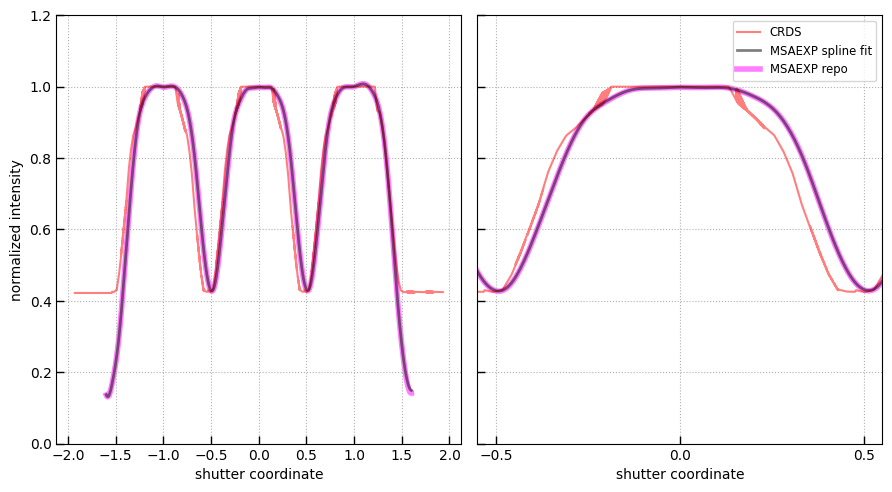

In [78]:
# Compare to the implemented correction
msa_bar, _wrapped = msaexp.utils.get_prism_bar_correction(xbin, num_shutters=num_shutters)

fig, axes = plt.subplots(1,2,figsize=(9,5), sharey=True)
axes[0].set_ylabel('normalized intensity')

for ax in axes:
    # Just show a single wavelength of the CRDS correction
    so = np.argsort(shutter_y[oky])
    ax.plot(shutter_y[oky][so], obj.bar[oky][so], color='r', alpha=0.5, label='CRDS')
    ax.set_xlabel('shutter coordinate')
    ax.grid()

    ax.plot(xbin, cbin, color='k', alpha=0.5, lw=2, label='MSAEXP spline fit')
    ax.plot(xbin, msa_bar, color='magenta', label='MSAEXP repo', lw=4, zorder=-10, alpha=0.5)
    
axes[1].set_xlim(-0.55, 0.55)
axes[1].set_xticks([-0.5, 0, 0.5])

axes[0].set_ylim(0, 1.2)

ax.legend()
fig.tight_layout(pad=1)

## Wavelength-dependent correction

Fit for the profile in wavelength bins.

The correction will then be derived by interpolating the spline coefficients at a given wavelength

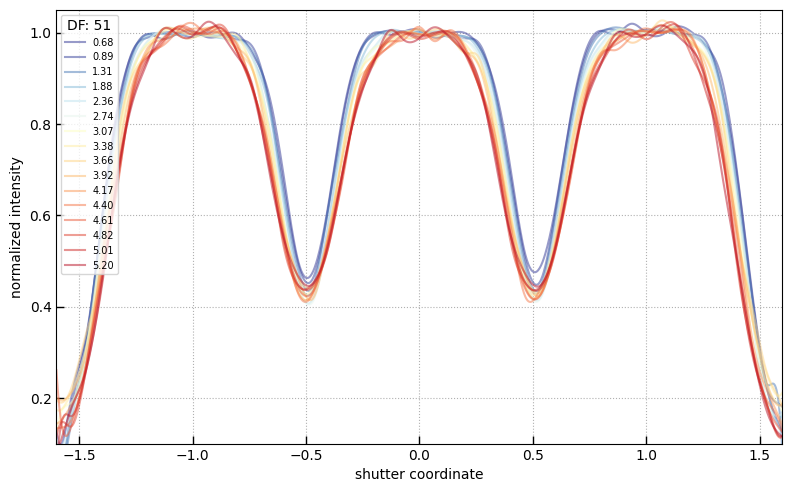

In [79]:
xbin = np.linspace(*bar_minmax, 1024)
xpeak = np.abs(xbin - np.round(xbin)) < 0.1

sbin = utils.bspline_templates(xbin, df=bar_df, get_matrix=True, minmax=bar_minmax)

fig, ax = plt.subplots(1,1,figsize=(8, 5))

ok2 = np.isfinite(fdata) & select_shutters

# Spaced in wavelength
wstep = 0.25
wbins = np.arange(0.75, 5.26, wstep) - wstep/2
wbins = np.hstack([wdata[ok2].min(), wbins, wdata[ok2].max()])

# Spaced in equal number of pixels
wbins = np.percentile(wdata[ok2], np.linspace(0, 100, 17))

wave_coeffs = []

# for wcen in wavelengths:
for wi in range(len(wbins)-1):
    ok2 = np.isfinite(fdata) & select_shutters
    ok2 &= (wdata >= wbins[wi]) & (wdata < wbins[wi+1])
    
    _bar_coeffs = np.linalg.lstsq(bspl[ok2,:], fdata[ok2], rcond=None)[0]
    #_bar_coeffs = np.linalg.lstsq(((bspl.T)/rndata).T[ok2,:], (fdata/rndata)[ok2], rcond=None)[0]

    cbin = sbin.dot(_bar_coeffs)
    cnorm = np.nanmean(cbin[xpeak])
    
    wave_coeffs.append(_bar_coeffs / cnorm)
    wcen = (wbins + np.gradient(wbins)/2)[wi]
    
    ax.plot(xbin, cbin/cnorm, c=plt.cm.RdYlBu_r(np.interp(wcen, [0.8, 5.4], [0,1])), alpha=0.5, label=f'{wcen:.2f}')

leg = ax.legend(loc='upper left', fontsize=7)
leg.set_title(f'DF: {bar_df}')

ax.grid()
ax.set_xlim(*bar_minmax)
ax.set_ylim(0.1, 1.05)
ax.set_xlabel('shutter coordinate')
ax.set_ylabel('normalized intensity')

fig.tight_layout(pad=1)

## Save coefficients to YAML

[msaexp/data/prism_3_bar_coeffs.yaml](https://github.com/gbrammer/msaexp/blob/main/msaexp/data/prism_3_bar_coeffs.yaml)

[msaexp/data/prism_3_bar_coeffs_wave.yaml](https://github.com/gbrammer/msaexp/blob/main/msaexp/data/prism_3_bar_coeffs_wave.yaml)

In [80]:
import yaml
def float_representer(dumper, value):
    text = "{0:.5f}".format(value)
    return dumper.represent_scalar("tag:yaml.org,2002:float", text)

yaml.add_representer(float, float_representer)

_header = """# empirical-bar-shadow.ipynb
# Determined from background shutters DD-2750
"""

##########
# No wavelength dependence
bar_spline = {}
bar_spline['coeffs'] = [float(_ci) for _ci in bar_coeffs]
bar_spline['minmax'] = list(bar_minmax)

with open(f'prism_{num_shutters}_bar_coeffs.yaml','w') as fp:
    fp.write(_header)
    yaml.dump(bar_spline, stream=fp)

##########
# with wavelength dependence
bar_spline = {}
bar_spline['wavelengths'] = [float(w) for w in (wbins + np.gradient(wbins)/2)[:-1]]
bar_spline['coeffs'] = [[float(_ci) for _ci in cw] for cw in np.array(wave_coeffs).T]
bar_spline['minmax'] = list(bar_minmax)

if False:
    #  print(yaml.dump(bar_spline))
    with open(f'prism_{num_shutters}_bar_coeffs_wave.yaml','w') as fp:
        fp.write(_header)
        yaml.dump(bar_spline, stream=fp)
    

## Show the correction in 2D

Note that the correction in `msaexp.utils.get_prism_wave_bar_correction` masks pixels outside of the `bar_minmax` range used to derive the correction.  These should to be the unilluminated pixels on the outer edge of the cutouts.

In [81]:
import msaexp.utils as msautils
wbar, _ = msautils.get_prism_wave_bar_correction(ydata[select_shutters],
                                                 wdata[select_shutters],
                                                 wrap=False,
                                                 num_shutters=num_shutters,
                                                )

fbar, _ = msautils.get_prism_bar_correction(ydata[select_shutters],
                                            wrap=False,
                                            num_shutters=num_shutters)

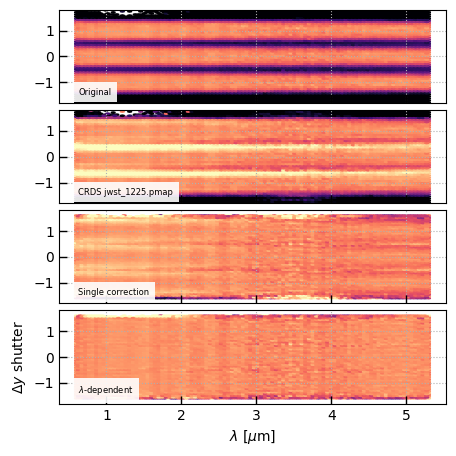

In [102]:
# fig, axes = plt.subplots(4,1,figsize=(8, 8), sharex=True, sharey=True)
fig, axes = plt.subplots(4,1,figsize=(4.5, 4.5), sharex=True, sharey=True)

plot_data = [(fdata[select_shutters], 'Original'),
             (fdata[select_shutters]/braw[select_shutters], 'CRDS jwst_1225.pmap'),
             (fdata[select_shutters]/fbar, 'Single correction'),
             (fdata[select_shutters]/wbar, r'$\lambda$-dependent'),
            ]

bin_xvalue = wdata
for i in range(4):
    ax = axes[i]
    ax.hexbin(bin_xvalue[select_shutters],
          ydata[select_shutters],
          C=plot_data[i][0],
          gridsize=(96,16*num_shutters),
          reduce_C_function=np.nanmedian, vmin=0.3, vmax=1.2,
          cmap='magma',
    )
    ax.text(0.05, 0.07, plot_data[i][1],
            ha='left', va='bottom',
            size=6,
            bbox={'fc':'w', 'alpha':0.9, 'ec':'None'},
            transform=ax.transAxes)
    ax.grid()

ax.set_ylim(-1.8, 1.8)
# ax.set_xlim(0.7, 5.3)
# ax.set_yticks([-1.5, -0.5, 0.5, 1.5])

ax.set_xlabel(r'$\lambda$ [$\mu\mathrm{m}$]')
# ax.set_ylabel('shutter offset')
ax.set_ylabel(r'$\Delta y$ shutter')

fig.tight_layout(pad=0.5)
fig.savefig('prism_bar_shadow_correction.pdf')

## Make a figure showing a single slitlet and the bar residuals

In [103]:
for k in bobj:    
    obj = bobj[k]
    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    if len(obj.info["shutter_state"][0]) != num_shutters:
        continue
    
    if 'nrs1' in k:
        continue
        
    print(k)
    break


jw02750002001.nrs2.002


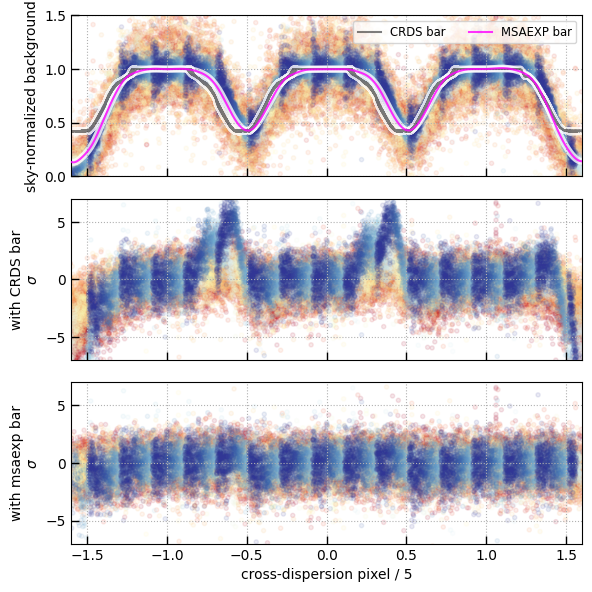

In [104]:
_sky = obj.sky_data['sky2d']
sn = obj.sci / obj.sky_data['sky2d']

shutter_y = obj.fixed_yshutter
cbar, _warp = msaexp.utils.get_prism_wave_bar_correction(shutter_y,
                                                         obj.wave,
                                                         wrap=False,
                                                         num_shutters=num_shutters)

cmap = 'RdYlBu_r'

fig, axes = plt.subplots(3,1,figsize=(6,6), sharex=True, sharey=False)

wso = np.argsort(obj.wave.flatten())[::-1]

# CRDS-corrected
ax = axes[1]
ax.scatter(shutter_y.flatten()[wso], ((sn - 1) / (np.sqrt(obj.var_total) / _sky)).flatten()[wso],
           alpha=0.1, c=obj.wave.flatten()[wso], vmin=0.7, vmax=5, cmap=cmap)

# This corrected
ax = axes[2]
oky = np.isfinite(shutter_y + obj.bar + sn) & (sn > 0) & (sn < 2)
so = np.argsort(shutter_y[oky])
dy = 0.03

ax.scatter(shutter_y.flatten()[wso],
           ((sn*obj.bar / cbar - 1) / (np.sqrt(obj.var_total) / _sky * obj.bar / cbar)).flatten()[wso], 
           alpha=0.1, c=obj.wave.flatten()[wso], vmin=0.7, vmax=5, cmap=cmap)


# Original data undoing CRDS correction
ax = axes[0]
ax.scatter(shutter_y.flatten()[wso],
           (sn*obj.bar).flatten()[wso],
           alpha=0.1,
           c=obj.wave.flatten()[wso],
           vmin=0.7, vmax=5, zorder=-1, cmap=cmap)

# Show CRDS and this correction
xso = np.argsort(shutter_y.flatten())
ax.plot(shutter_y.flatten()[xso], obj.bar.flatten()[xso], alpha=0.8, lw=5, color='w', zorder=1)
ax.plot(shutter_y.flatten()[xso], obj.bar.flatten()[xso], alpha=0.5, color='k', label='CRDS bar', zorder=10)

# MSAEXP correction
my_bar, _wrapped = msaexp.utils.get_prism_bar_correction(xbin, num_shutters=num_shutters)

ax.plot(xbin, my_bar, color='w', alpha=0.8, zorder=1, lw=5)
ax.plot(xbin, my_bar, color='magenta', alpha=0.8, label='MSAEXP bar', zorder=11)

ax.legend(ncol=2, loc='upper right')

ax.set_xticks(np.arange(-2, 2.1, 0.5))
ax.set_xlim(*bar_minmax)

axes[0].set_ylim(0, 1.5)   
for ax in axes[1:]:
    ax.set_ylim(-7, 7)

axes[2].set_xlabel('cross-dispersion pixel / 5')
axes[0].set_ylabel('sky-normalized background')
axes[1].set_ylabel('with CRDS bar\n' + r'$\sigma$')
axes[2].set_ylabel('with msaexp bar\n' + r'$\sigma$')

for ax in axes:
    ax.grid()

fig.tight_layout(pad=1)
fig.savefig('diagnose_bar_correction.png')


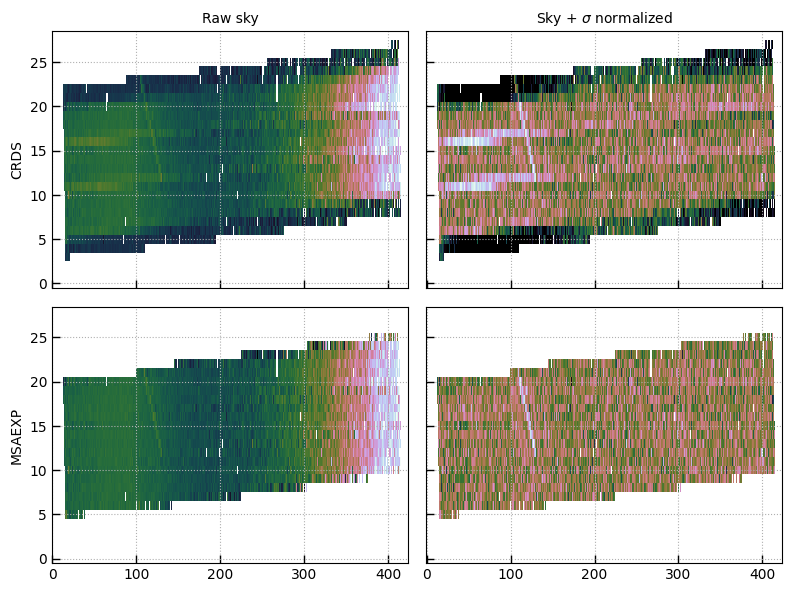

In [105]:
# Show the correction on one cutout

fig, axes = plt.subplots(2,2,figsize=(8, 6), sharex=True, sharey=True)

cmap = 'cubehelix'

# Data
ax = axes[0][0]
ax.imshow(obj.sci[0].reshape(obj.sh), aspect='auto', vmin=-0.1, vmax=0.5, cmap=cmap)
ax.set_ylabel('CRDS')
ax.set_title('Raw sky')

ax = axes[0][1]
ax.imshow(((obj.sci / _sky - 1) / (np.sqrt(obj.var_total)/ _sky))[0].reshape(obj.sh),
          aspect='auto', vmin=-7, vmax=7, cmap=cmap)
ax.set_title(r'Sky + $\sigma$ normalized')

# Updated correction
ax = axes[1][0]
ax.imshow((obj.sci*obj.bar/cbar)[0].reshape(obj.sh), aspect='auto', vmin=-0.1, vmax=0.5, cmap=cmap)
ax.set_ylabel('MSAEXP')
ax = axes[1][1]
ax.imshow(((obj.sci * obj.bar/cbar / _sky - 1) / (np.sqrt(obj.var_total) * obj.bar / cbar / _sky))[0].reshape(obj.sh),
          aspect='auto', vmin=-7, vmax=7, cmap=cmap)

for i in range(2):
    for j in range(2):
        axes[i][j].grid()
        
fig.tight_layout(pad=1)
